# Endocrine Pancreas

Endocrine development in the pancreas with lineage commitment to four major fates: α, β, δ and ε-cells. See [here](https://scvelo.readthedocs.io/scvelo.datasets.pancreas.html) for more details.

Dataset from [Bastidas-Ponce et al. (2018)](https://dev.biologists.org/content/146/12/dev173849.abstract).

In [1]:
import scvelo as scv
scv.logging.print_version()

Running scvelo 0.2.0 (python 3.7.3) on 2020-05-13 09:39.


In [2]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization

### Load and cleanup the data

The following analysis is based on the in-built [pancreas dataset](https://scvelo.readthedocs.io/scvelo.datasets.pancreas.html).

To run velocity analysis on your own data, read your file (loom, h5ad, xlsx, csv, tab, txt …) to an AnnData object with `adata = scv.read('path/file.loom', cache=True)`.

If you want to merge your loom file into an already existing AnnData object, use `scv.utils.merge(adata, adata_loom)`.

In [3]:
adata = scv.datasets.pancreas()

In [4]:
# show proportions of spliced/unspliced abundances
scv.utils.show_proportions(adata)
adata

Abundance of ['spliced', 'unspliced']: [0.83 0.17]


AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

### Preprocess the data

Preprocessing that is necessary consists of :
- gene selection by **detection** (detected with a minimum number of counts) and **high variability** (dispersion).
- **normalizing** every cell by its initial size and **logarithmizing** X.

Further, we need the first and second order moments (basically mean and uncentered variance) computed among nearest neighbors in PCA space. 
First order is needed for deterministic velocity estimation, while stochastic estimation also requires second order moments.

In [5]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)


Filtered out 20801 genes that are detected in less than 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)


### Compute velocity and velocity graph
The gene-specific velocities are obtained by fitting a ratio between precursor (unspliced) and mature (spliced) mRNA abundances that well explains the steady states (constant transcriptional state) and then computing how the observed abundances deviate from what is expected in steady state. (We will soon release a version that does not rely on the steady state assumption anymore).

Every tool has its plotting counterpart. The results from `scv.tl.velocity`, for instance, can be visualized using `scv.pl.velocity`.

In [6]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


This computes the (cosine) correlation of potential cell transitions with the velocity vector in high dimensional space.
The resulting velocity graph has dimension $n_{obs} \times n_{obs}$ and summarizes the possible cell state changes (given by a transition from one cell to another) that are well explained through the velocity vectors. The graph is, for instance, used to project the velocities into a low-dimensional embedding.

In [7]:
scv.tl.velocity_graph(adata)

computing velocity graph
    finished (0:00:11) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


### Plot results

Velocities are projected onto any embedding specified in `basis` and visualized in one of three available ways: on single cell level, on grid level, or as streamplot as shown here.

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


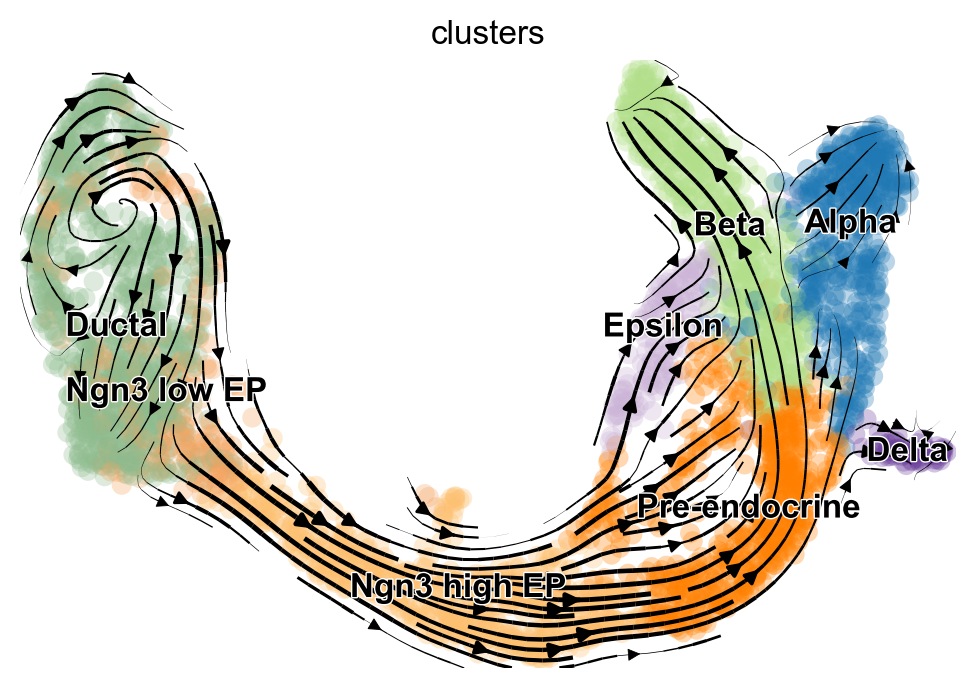

In [8]:
scv.pl.velocity_embedding_stream(adata, basis='umap')


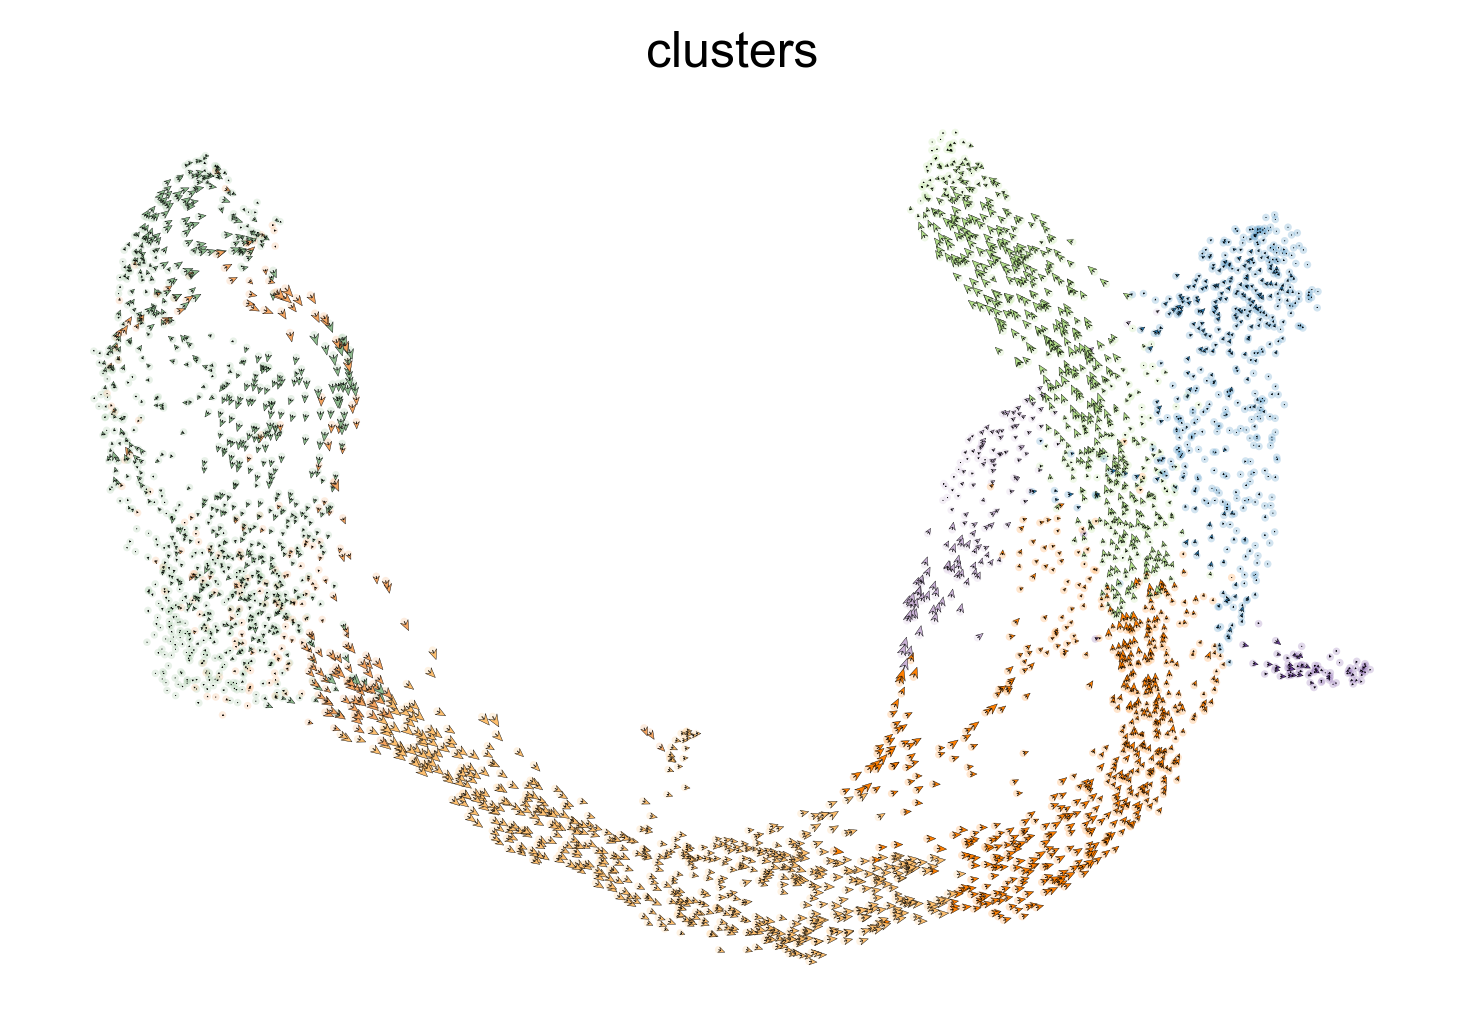

In [9]:
scv.pl.velocity_embedding(adata, basis='umap', arrow_length=2, arrow_size=1.5, dpi=150)


In [10]:
scv.tl.recover_dynamics(adata)

recovering dynamics
    finished (0:10:30) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [11]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing terminal states
    identified 2 regions of root cells and 1 region of end points 
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


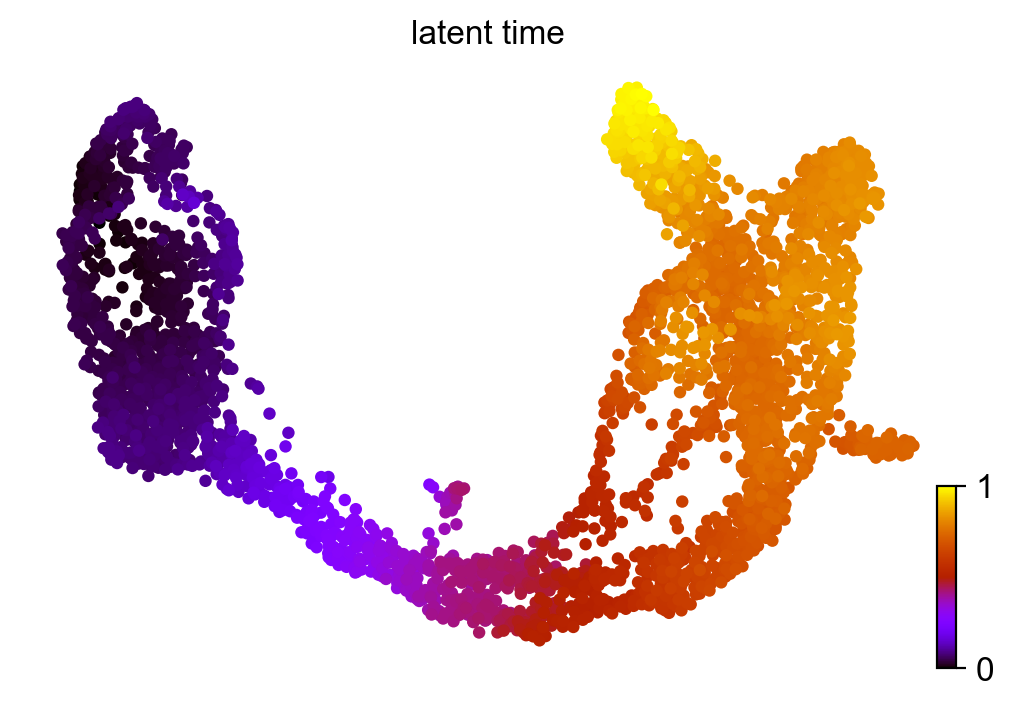

In [12]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80, colorbar=True)

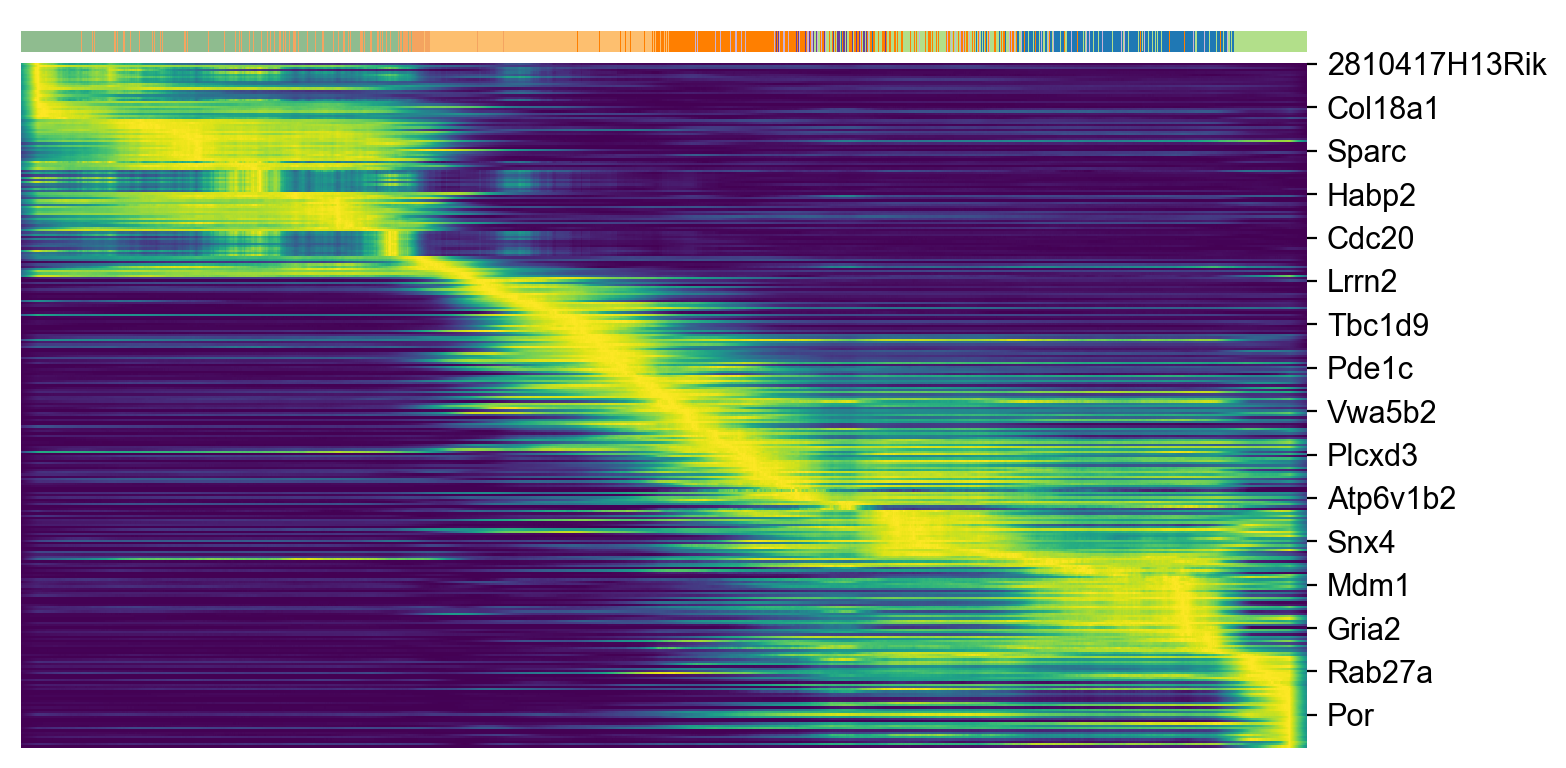

In [13]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata, var_names=top_genes, tkey='latent_time', n_convolve=100, col_color='clusters')

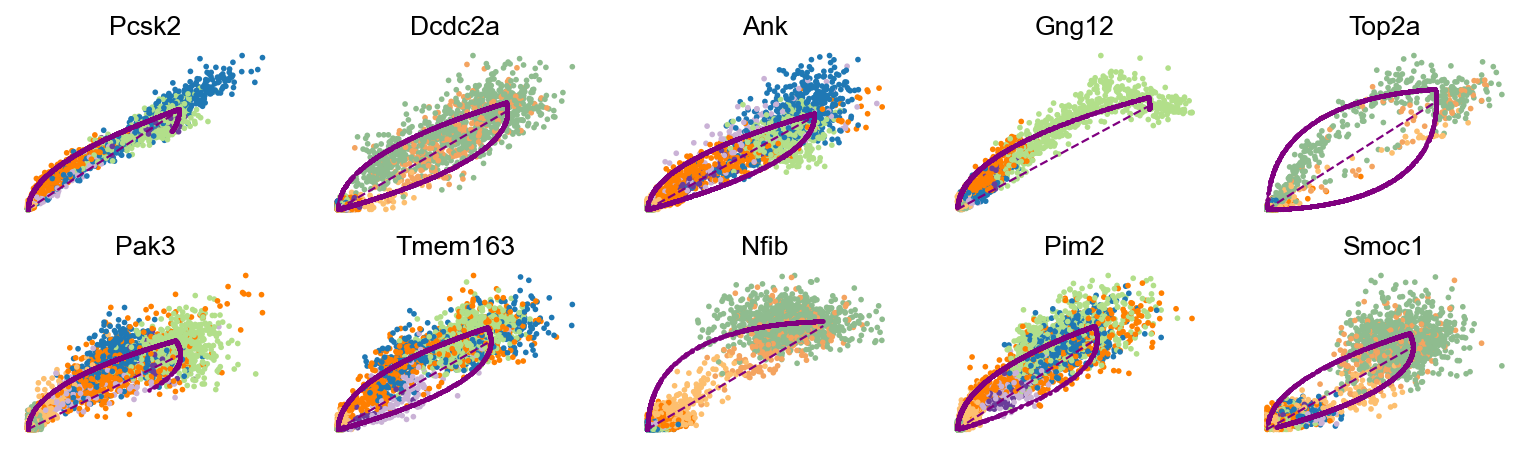

In [14]:
scv.pl.scatter(adata, basis=top_genes[:10], frameon=False, ncols=5)

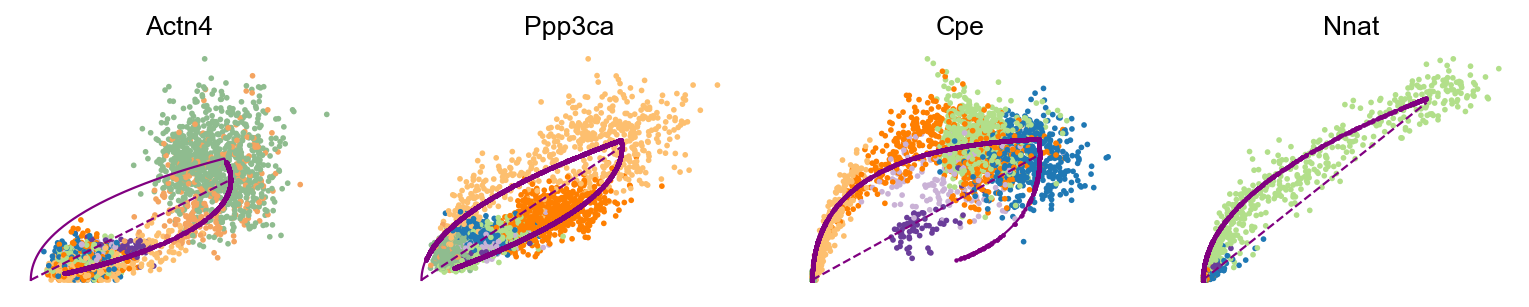

In [15]:
scv.pl.scatter(adata, basis=['Actn4', 'Ppp3ca', 'Cpe', 'Nnat'], frameon=False)

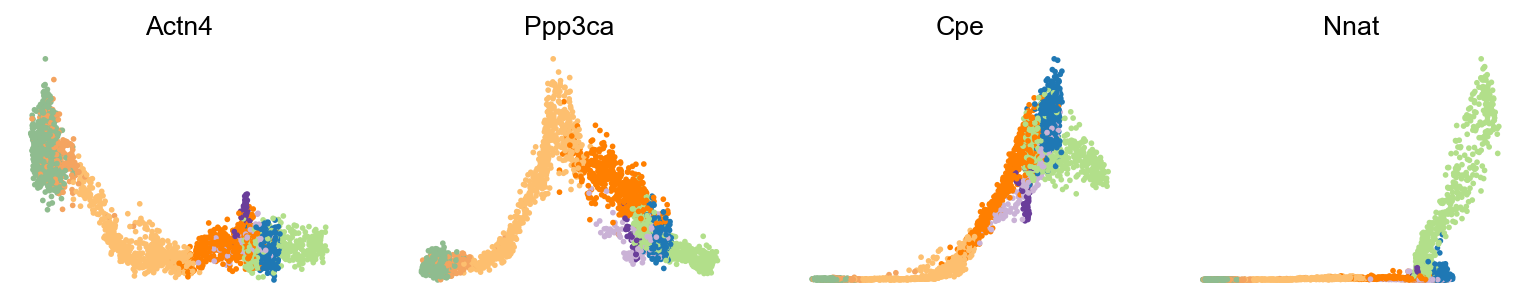

In [16]:
scv.pl.scatter(adata, x='latent_time', y=['Actn4', 'Ppp3ca', 'Cpe', 'Nnat'], frameon=False)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


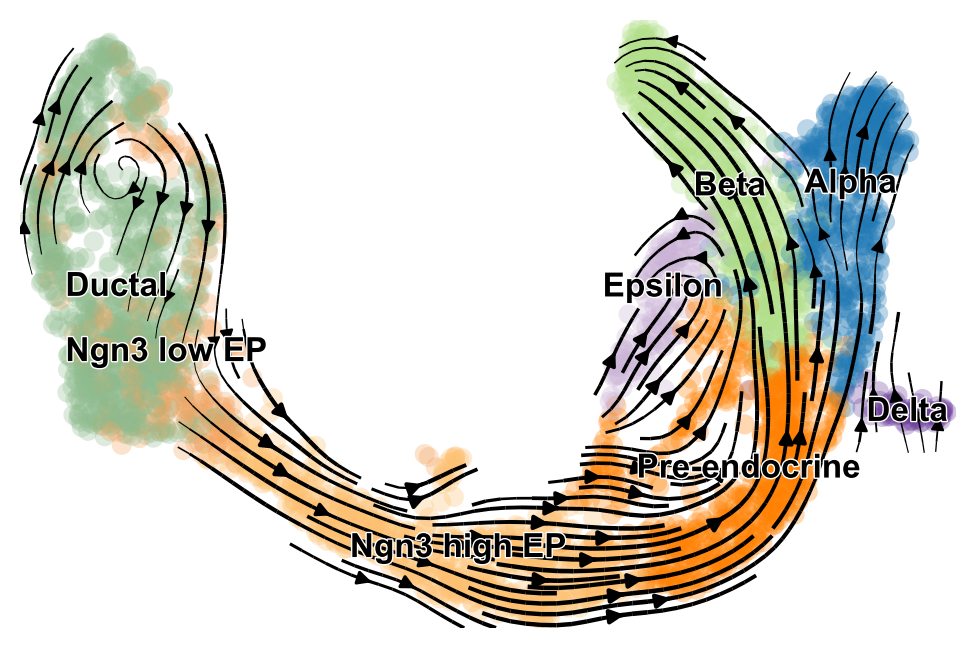

In [17]:
scv.pl.velocity_embedding_stream(adata, basis='umap', title='', smooth=.8, min_mass=4)